In [1]:
import os
from pathlib import Path

import json
import joblib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
%matplotlib inline

from searchnets.plot.heatmaps import p_item_heatmap, acc_err_heatmap

/home/ildefonso/anaconda3/envs/searchstims-new/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ildefonso/anaconda3/envs/searchstims-new/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ildefonso/anaconda3/envs/searchstims-new/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ilde

#### get paths to all the data n' results n' stuff

In [2]:
jsons_dir = Path('../../../data/visual_search_stimuli/json/')
jsons = sorted(
    list(jsons_dir.glob('*.json'))
)
jsons = [str(json_path) for json_path in jsons]

data_gz_dir = Path('../../../data/data_prepd_for_nets/')
data_gzs = sorted(
    list(data_gz_dir.glob('*.gz'))
)
data_gzs = [str(data_gz) for data_gz in data_gzs]

results_gz_dir = Path('../../../data/results/')
results_gzs = sorted(
    list(results_gz_dir.glob('*/*.gz'))
)
results_gzs = [str(results_gz) for results_gz in results_gzs]

#### get just the paths we need, e.g. AlexNet fine-tuning

In [3]:
stim_abbrevs = ['RVvGV', 'RVvRHGV', '2_v_5']

In [4]:
def p_item_metric_heatmap_plots(json_fname, data_gz_fname, results_gz_fname, stim_abbrev, 
                                metric='err', num_nets=5, set_sizes = (1, 2, 4, 8), figsize=(7.5, 10),
                               cmap='rainbow', save_as=None):
    """plot p_item and metric heatmaps"""
    fig = plt.figure(figsize=figsize)
    grid = AxesGrid(fig, (0, 0.7, 1, 0.3),
                    nrows_ncols=(1, 4),
                    axes_pad=0.05,
                    share_all=True,
                    label_mode="L",
                    cbar_location="right",
                    cbar_mode="single",
                    )

    ps = []
    for ax_ind, set_size in enumerate(set_sizes):
        set_size = str(set_size)
        p, im,ax = p_item_heatmap(json_fname=json_fname,
                                  data_gz_fname=data_gz_fname,
                                  stim_abbrev=stim_abbrev,
                                  set_size=set_size,
                                  data_set='train',
                                  item_char='t',
                                  vmin=0.,
                                  vmax=0.1,
                                  ax=grid[ax_ind],
                                  cmap=cmap)
        # ax.set_title(f'set size: {set_size}', fontsize=12)
        ps.append(p)

    grid.cbar_axes[0].colorbar(im, ticks=np.arange(0.02,0.1,0.02))
    for cax in grid.cbar_axes:
        cax.toggle_label(True)
    # fig.suptitle('prob(target) in training set')

    ## next 'figure'(s)
    grid2 = AxesGrid(fig, (0, 0, 1, 0.65),
                     nrows_ncols=(num_nets, 4),
                     axes_pad=0.05,
                     share_all=True,
                     label_mode="L",
                     cbar_location="right",
                     cbar_mode="single",
                     cbar_size=0.25,
                     )

    m_arrs = []
    for net_num in range(num_nets):
        m_arrs_this_net = []

        for set_size_ind, set_size in enumerate(set_sizes):
            ax_ind = (net_num * len(set_sizes)) + set_size_ind
            m_arr, im, ax = acc_err_heatmap(json_fname=json_fname,
                                            data_gz_fname=data_gz_fname,
                                            results_gz_fname=results_gz_fname,
                                            net_num=net_num,
                                            stim_abbrev=stim_abbrev,
                                            set_size=set_size,
                                            data_set='test',
                                            metric=metric,
                                            vmin=0.,
                                            vmax=1.0,
                                            ax=grid2[ax_ind],
                                            cmap=cmap)
            m_arrs_this_net.append(m_arr)

        m_arrs.append(m_arrs_this_net)

    grid2.cbar_axes[0].colorbar(im)

    for cax in grid.cbar_axes:
        cax.toggle_label(True)
    
    # fig.suptitle('error rate every time item appeared in this cell in test set')
    
    if save_as:
        plt.savefig(save_as)
    
    return ps, m_arrs

In [5]:
alexnet_finetune_jsons = [a_json for a_json in jsons 
                          if any([f'alexnet_{stim_abbrev}' in a_json for stim_abbrev in stim_abbrevs])
                         ]
alexnet_finetune_jsons = sorted(alexnet_finetune_jsons)

alexnet_finetune_data_gzs = [data_gz for data_gz in data_gzs
                             if 'alexnet_finetune' in data_gz]
alexnet_finetune_data_gzs = sorted(alexnet_finetune_data_gzs)

alexnet_finetune_results_gzs = [results_gz for results_gz in results_gzs
                                if 'alexnet_finetune' in results_gz]
alexnet_finetune_results_gzs = sorted(alexnet_finetune_results_gzs)

#### heatmaps of probability(any item) and heatmaps of error for each trained network, for finetune approach

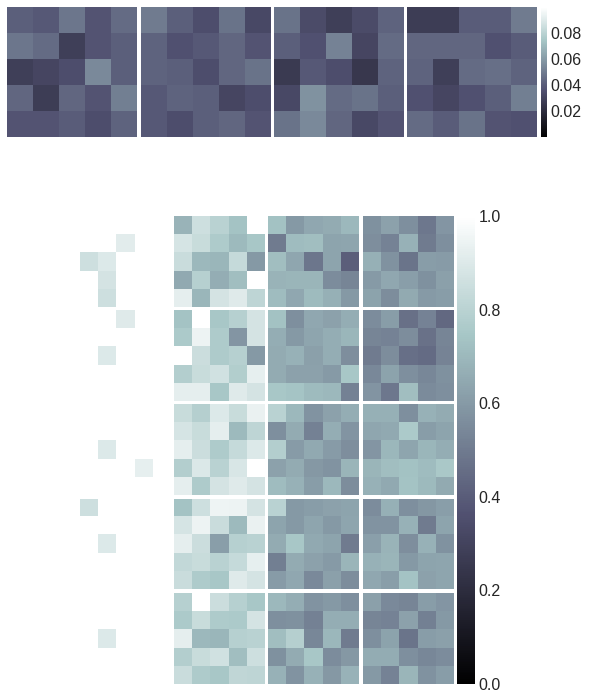

In [6]:
ps_alexnet_finetune, acc_alexnet_finetune = p_item_metric_heatmap_plots(json_fname=alexnet_finetune_jsons[0],
                                                                        data_gz_fname=alexnet_finetune_data_gzs[0],
                                                                        results_gz_fname=alexnet_finetune_results_gzs[0],
                                                                        stim_abbrev='2_v_5', cmap='bone', metric='acc',
                                                                        save_as='heatmap-alexnet-finetune.png')

#### heatmaps of probability(any item) and heatmaps of error with "normal learning rate" approach with "finetune" dataset

In [7]:
alexnet_train_finetune_results_gzs = [results_gz for results_gz in results_gzs
                                if 'alexnet_train_finetune' in results_gz]
alexnet_train_finetune_results_gzs = sorted(alexnet_train_finetune_results_gzs)

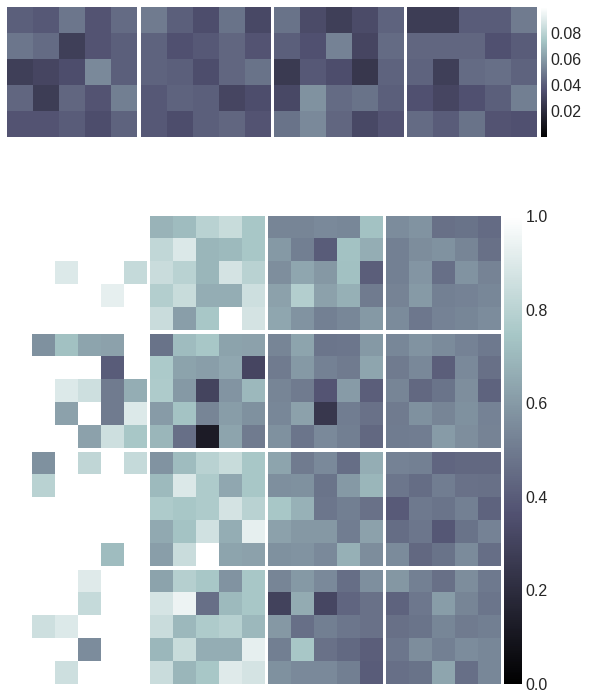

In [8]:
# notice we use json and data_gz from finetune since they were the same
ps_alexnet_tr_finetune, acc_alexnet_tr_finetune = p_item_metric_heatmap_plots(json_fname=alexnet_finetune_jsons[0],
                                                                              data_gz_fname=alexnet_finetune_data_gzs[0],
                                                                              results_gz_fname=alexnet_train_finetune_results_gzs[0],
                                                                              stim_abbrev='2_v_5', num_nets=4, cmap='bone', metric='acc')

In [9]:
alexnet_train_jsons = [a_json for a_json in jsons 
                          if any([f'alexnet_train_{stim_abbrev}' in a_json for stim_abbrev in stim_abbrevs])
                         ]
alexnet_train_jsons = sorted(alexnet_train_jsons)

alexnet_train_data_gzs = [data_gz for data_gz in data_gzs
                          if any([f'alexnet_train_{stim_abbrev}' in data_gz for stim_abbrev in stim_abbrevs])
                         ]
alexnet_train_data_gzs = sorted(alexnet_train_data_gzs)

alexnet_train_results_gzs = [results_gz for results_gz in results_gzs
                                if any([f'alexnet_train_{stim_abbrev}' in results_gz for stim_abbrev in stim_abbrevs])
                            ]
alexnet_train_results_gzs = sorted(alexnet_train_results_gzs)

#### heatmaps of probability(any item) and heatmaps of error with "normal learning rate" approach, and a larger dataset where number of training samples increases linearly with set size

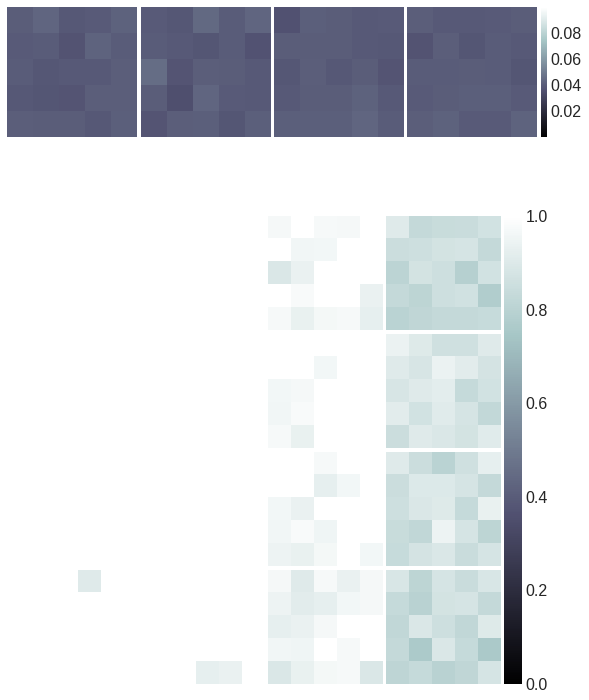

In [10]:
# notice we use json and data_gz from finetune since they were the same
ps_alexnet_train, acc_alexnet_train = p_item_metric_heatmap_plots(json_fname=alexnet_train_jsons[0],
                                                                              data_gz_fname=alexnet_train_data_gzs[0],
                                                                              results_gz_fname=alexnet_train_results_gzs[0],
                                                                              stim_abbrev='2_v_5', num_nets=4, cmap='bone', metric='acc',
                                                                              save_as='heatmap-alexnet-normal-lr-augmented-dataset.png')

#### comparing standard deviation of probability(item appear) suggest that yes, higher standard deviation correlates with higher error

In [11]:
std_p_item_finetune = np.asarray([p_item.std() for p_item in ps_alexnet_finetune])
std_acc_finetune = [
    np.asarray([acc.std() for acc in acc_net])
    for acc_net in acc_alexnet_finetune
]

std_p_item_normal_lr = np.asarray([p_item.std() for p_item in ps_alexnet_train])
std_acc_normal_lr = [
    np.asarray([acc.std() for acc in acc_net])
    for acc_net in acc_alexnet_train
]

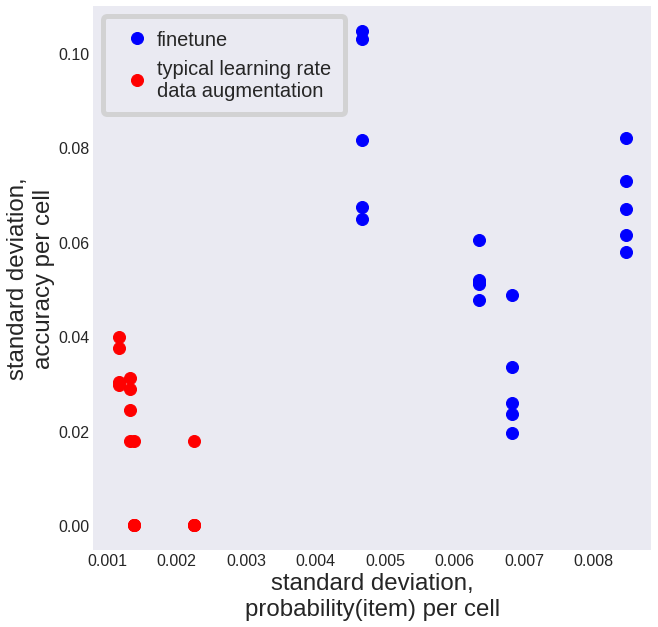

In [47]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

for net_num, acc_net in enumerate(std_acc_finetune):
    if net_num == 0:
        label='finetune'
    else:
        label=None
        
    ax.plot(std_p_item_finetune, acc_net, 
            linestyle='none', marker='o', color='blue', 
            markersize=12, label=label)

for net_num, acc_net in enumerate(std_acc_normal_lr):
    if net_num == 0:
        label='typical learning rate\ndata augmentation'
    else:
        label=None

    ax.plot(std_p_item_normal_lr, acc_net, 
            linestyle='none', marker='o', color='red', 
            markersize=12, label=label)
    
ax.set_xlabel('standard deviation,\nprobability(item) per cell', fontsize=24)

ax.set_ylabel('standard deviation,\naccuracy per cell', fontsize=24)

legend = plt.legend(bbox_to_anchor=(0,1), loc='upper left', fontsize=20,
                    frameon=True, borderpad=0.7, handletextpad=0)
legend.get_frame().set_linewidth(5)

plt.savefig('std-dev-acc-v-p-item.png', bbox_inches='tight')

In [45]:
std_p_item_finetune

array([0.00681909, 0.00466369, 0.00846316, 0.00634429])